## Chapter 15 Understanding Strategy Risk

## Introduction

As the majority of the investment strategies have exit conditions (either in a form of stop loss or take profit), the outcomes can be modeled using a binomial process. This approach shows whether the strategy is sensitive to minor changes in betting frequency, odds, and payouts. 

In this notebook, the exercises from Chapter-15 in the book "Advances in Financial Machine Learning" are implemented. 

In [1]:
# Import packages
import numpy as np
import pandas as pd
import scipy.stats as ss
from random import gauss
from itertools import product
import matplotlib.pyplot as plt

# Import MlFinLab tools
import mlfinlab
from mlfinlab.backtest_statistics.statistics import (sharpe_ratio, probabilistic_sharpe_ratio)

## Question-15.1

### A portfolio manager intends to launch a strategy that targets an annualized SR of 2. Bets have a precision rate of 60%, with weekly frequency. The exit conditions are 2% for profit-taking, and –2% for stop-loss.

### (a) Is this strategy viable?

In [2]:
"""
We assume the exit conditions to be for log returns, therefore we can assume payouts being symmetric.

Using the Snippet 15.1:
"""

trades_per_year = 52
out,p=[],.6

for i in range(1000000):
    rnd=np.random.binomial(n=1,p=p)
    x=(1 if rnd==1 else -1)
    out.append(x)

#Using mlfinlab function that takes pd.Series as an input
out = pd.Series(out)
annualized_sr = sharpe_ratio(out, entries_per_year=trades_per_year)

print('Sharpe Ratio is' , annualized_sr)

Sharpe Ratio is 1.4714687650833804


Wigh given parameters, the Sharpe Ratio of the strategy falls below the desired threshold of 2, therefore the strategy is __not__ viable.

### (b) _Ceteris paribus_, what is the required precision rate that would make the strategy profitable?

In [3]:
"""
Using the formula solution:
"""

n, SR = 52, 2

precision = 1/2 * (1 + (1-n/(SR**2+n))**(1/2))

print('Required precision is' , precision)

Required precision is 0.6336306209562121


So, an increase of precision from 0.6 set by the manager to 0.63363 will make the strategy profitable at a required Sharpe Ratio of 2.

### (c) For what betting frequency is the target achievable?

Using formula solutions:

$\frac{n}{\theta^2+n}=-4p^2+4p$

$n=(-4p^2+4p)*(\theta^2+n)$

$n - n(-4p^2+4p)=(-4p^2+4p)*\theta^2$

$n=\frac{(-4p^2+4p)*\theta^2}{1+4p^2-4p}$

In [4]:
p, SR = 0.6, 2

n = ((-4*p**2 +4*p) * SR**2) / (1 + 4*p**2 - 4*p)

print('Required frequeny is' , n)

Required frequeny is 95.99999999999991


96 trades per year should be made instead of 52 (or ~85% more trades) to achieve the target Sharpe Ratio.

### (d) For what profit-taking threshold is the target achievable?

Changing the profit-taking threshold will bring us to the asymmetric payouts model, where the solution is:

$\theta=\frac{(\pi_{+}-\pi_{-})p+\pi_{-}}{(\pi_{+}-\pi_{-})\sqrt{p(1-p)}}\sqrt{n}$

$(\pi_{+}-\pi_{-})(\theta*\sqrt{p(1-p)})=((\pi_{+}-\pi_{-})p+\pi_{-})\sqrt{n}$

$(\pi_{+}-\pi_{-})(\theta*\sqrt{p(1-p)}-p\sqrt{n})=\pi_{-}\sqrt{n}$

$\pi_{+}-\pi_{-}=\frac{\pi_{-}\sqrt{n}}{(\theta*\sqrt{p(1-p)}-p\sqrt{n})}$

$\pi_{+}=\frac{\pi_{-}\sqrt{n}}{(\theta*\sqrt{p(1-p)}-p\sqrt{n})}+\pi_{-}$

In [5]:
p, SR, sl, n = 0.6, 2, -0.02, 52

tp = (sl * n**(1/2)) / (SR * (p*(1-p))**(1/2) - p * n**(1/2)) + sl

print('Required take-profit is' , tp)

Required take-profit is 0.023091676456151216


Achieving the target is possible if the take-profit is moved from 0.02 to ~0.023 (or 15,5% higher).

### (e) What would be an alternative stop-loss?

Again, using the asymmetric payouts model solution:

$\theta=\frac{(\pi_{+}-\pi_{-})p+\pi_{-}}{(\pi_{+}-\pi_{-})\sqrt{p(1-p)}}\sqrt{n}$

$(\pi_{+}-\pi_{-})(\theta*\sqrt{p(1-p)})=((\pi_{+}-\pi_{-})p+\pi_{-})\sqrt{n}$

$(\pi_{+}-\pi_{-})(\theta*\sqrt{p(1-p)}-p\sqrt{n})=\pi_{-}\sqrt{n}$

$\pi_{-}(\theta*\sqrt{p(1-p)}-p\sqrt{n})+\pi_{-}\sqrt{n} = \pi_{+}(\theta*\sqrt{p(1-p)}-p\sqrt{n})$

$\pi_{-}(\theta*\sqrt{p(1-p)}-p\sqrt{n}+ \sqrt{n}) = \pi_{+}(\theta*\sqrt{p(1-p)}-p\sqrt{n})$

$\pi_{-} = \frac{\pi_{+}(\theta*\sqrt{p(1-p)}-p\sqrt{n})}{\theta*\sqrt{p(1-p)}-p\sqrt{n}+ \sqrt{n}}$

In [6]:
p, SR, tp, n = 0.6, 2, 0.02, 52

sl = (tp * (SR * (p*(1-p))**(1/2) - p * n**(1/2))) / (SR * (p*(1-p))**(1/2) - p * n**(1/2) + n**(1/2))

print('Required stop-loss is' , sl)

Required stop-loss is -0.017322258986243812


An alternative stop-loss would be ~-0.0173 instead of -0.02 (or 13,4% lower).

## Question-15.2

### Following up on the strategy from exercise 1.

### (a) What is the sensitivity of SR to a 1% change in each parameter?

In [7]:
"""
For the original parameters:
"""

p, n = 0.6, 52

SR_sym = lambda p, n: (2*p - 1) / (2 * (p*(1-p))**(1/2)) * (n)**(1/2)

# Precision rate
print('Change of 1% in percision rate shifts SR from' , SR_sym(p, n), 'to',
      SR_sym(p * 1.01, n), 'or', (SR_sym(p * 1.01, n)-SR_sym(p, n))/SR_sym(p, n)*100, '%')

# Trading frequency
print('Change of 1% in trading frequency shifts SR from' , SR_sym(p, n), 'to',
      SR_sym(p, n * 1.01), 'or', (SR_sym(p, n* 1.01)-SR_sym(p, n))/SR_sym(p, n)*100, '%')

sl, tp = -0.02, 0.02

SR_asym = lambda p, n, sl, tp: ((tp - sl) * p + sl) / ((tp - sl) * (p*(1-p))**(1/2)) * n**(1/2)

# Stop-loss
print('Change of 1% in stop-loss shifts SR from' , SR_asym(p, n, sl, tp), 'to',
      SR_asym(p, n , sl * 1.01, tp), 'or', (SR_asym(p, n, sl * 1.01, tp)-SR_asym(p, n, sl, tp))/SR_asym(p, n, sl, tp)*100, '%')

# Take-profit
print('Change of 1% in take-profit shifts SR from' , SR_asym(p, n, sl, tp), 'to',
      SR_asym(p, n , sl , tp * 1.01), 'or', (SR_asym(p, n, sl, tp * 1.01)-SR_asym(p, n, sl, tp))/SR_asym(p, n, sl, tp)*100, '%')

Change of 1% in percision rate shifts SR from 1.4719601443879742 to 1.5643110535917948 or 6.274008814431532 %
Change of 1% in trading frequency shifts SR from 1.4719601443879742 to 1.4793016370346288 or 0.4987562112089074 %
Change of 1% in stop-loss shifts SR from 1.4719601443879746 to 1.435344220398224 or -2.487562189054722 %
Change of 1% in take-profit shifts SR from 1.4719601443879746 to 1.5085760683777247 or 2.487562189054692 %


The Sharpe Ratio of the original model is most sensitive towards changes in precision rate. The trading frequency 1% change affects SR 12 times less than the precision rate change. Changes of SR from changes in stop-loss or take-profit values are symmetric.

### (b) Given these sensitivities, and assuming that all parameters are equally hard to improve, which one offers the lowest hanging fruit?

In this situation improving the precision rate would have the best effect on Sharpe Ratio, next goes both stop-loss decrease and take-profit increase. Trading frequency would have the least effect on SR.

### (c) Does changing any of the parameters in exercise 1 impact the others? For example, does changing the betting frequency modify the precision rate, etc.?

In the model, we assumed that changes in the input values - precision rate, frequency rate, stop-loss, and take-profit only affect the Sharpe Ratio. However, in real life examples increase in the betting frequency may decrease the precision rate, as trading opportunities that are less certain are taken.

## Question-15.3

### Suppose a strategy that generates monthly bets over two years, with returns following a mixture of two Gaussian distributions. The first distribution has a mean of –0.1 and a standard deviation of 0.12. The second distribution has a mean of 0.06 and a standard deviation of 0.03. The probability that a draw comes from the first distribution is 0.15.

### (a) Following Lopez de Prado and Peijan [2004] and Lopez de Prado and Foreman [2014], derive the first four moments for the mixture’s returns.

From _"A mixture of Gaussians approach to mathematical portfolio oversight: the EF3M algorithm"_ - Lopez de Prado and Foreman [2014], Appendix 1:

$E[r] = \sum_{j=1}^m p_j\mu_j$

$E[r^2] = \sum_{j=1}^m p_j (\sigma_j^2 + \mu_j^2)$

$E[r^3] = \sum_{j=1}^m p_j (3\sigma_j^2\mu_j + \mu_j^3)$

$E[r^4] = \sum_{j=1}^m p_j (3\sigma_j^4 + 6\sigma_j^2\mu_j^2 + \mu_j^4)$

In [8]:
μ1, μ2, σ1, σ2, p = -0.1, 0.06, 0.12, 0.03, 0.15

E_r1 = p*μ1 + (1-p)*μ2
print('First moment for the returns:', E_r1)

E_r2 = p*(σ1**2 + μ1**2) + (1-p)*(σ2**2 + μ2**2)
print('Second moment for the returns:', E_r2)

E_r3 = p*(3 * σ1**2 * μ1 + μ1**3) + (1-p)*(3 * σ2**2 * μ2 + μ2**3)
print('Third moment for the returns:', E_r3)

E_r4 = p*(3 * σ1**4 + 6 * σ1**2 * μ1**2 + μ1**4) + (1-p)*(3 * σ2**4 + 6 * σ2**2 * μ2**2 + μ2**4)
print('Fourth moment for the returns:', E_r4)

First moment for the returns: 0.036
Second moment for the returns: 0.0074849999999999995
Third moment for the returns: -0.00047670000000000004
Fourth moment for the returns: 0.0002675175


### (b) What is the annualized SR?

Sharpe Ratio from moments:

$V[r] = E[r^2] - E[r]^2$

$\theta = \frac{nE[r]}{\sqrt{nV[r]}}$

$\theta = \frac{\sqrt{n}E[r]}{\sqrt{E[r^2] - E[r]^2}}$

In [9]:
n, years = 12, 2

SR = (n**(1/2) * E_r1) / (E_r2 - E_r1**2)**(1/2)
print('Annualized Sharpe Ratio:', SR)

Annualized Sharpe Ratio: 1.5851956884937564


### (c) Using those moments, compute PSR[1] (see Chapter 14). At a 95% confidence level, would you discard this strategy?

From Chapter 14:

$PSR[SR^*] = z[\frac{(SR - SR^*)\sqrt{T-1}}{\sqrt{1-\gamma_3SR + \frac{\gamma_4-1}{4}SR^2}}]$

In [10]:
"""
As our strategy returns are a combination of two Gaussian, they are Gaussian, so skewness = 0, kurtosis = 3.
"""

γ3, γ4, T, SR_ = 0, 3, years * n, 1

# Using mlfinlab finction
probabilistic_sr = probabilistic_sharpe_ratio(observed_sr=SR, 
                                                                     benchmark_sr=SR_, 
                                                                     number_of_returns=T, 
                                                                     skewness_of_returns=γ3, 
                                                                     kurtosis_of_returns=γ4)

print('Probabilistic Sharpe Ratio:', probabilistic_sr)

Probabilistic Sharpe Ratio: 0.969142321714641


According to the PSR statistic description in Chapter 14, it should exceed 0.95 for the 5% significance level. Our calculated PSR is above that threshold, therefore we __do not discard__ the strategy.

## Question-15.4

### Using Snippet 15.5, compute $P[p < p_{\theta^*=1}]$ for the strategy described in exercise 3. At a significance level of 0.05, would you discard this strategy? Is this result consistent with PSR[$\theta^*$]?

In [11]:
"""
Snippet 15.5 with needed parameters:
"""

def binHR(sl, pt, freq, tSR):
    """
    Given a trading rule characterized by the parameters {sl, pt, freq},
    what's the min precision p required to achieve a Sharpe ratio tSR?
    
    :param sl: (float) Stop loss threshold.
    :param pt: (float) Profit taking threshold.
    :param freq: (float) Number of bets per year.
    :param tSR: (float) Target annual Sharpe ratio.
    :return: (float) The min precision rate p required to achieve tSR.
    """

    a = (freq+tSR**2)*(pt-sl)**2
    b = (2*freq*sl-tSR**2*(pt-sl))*(pt-sl)
    c = freq*sl**2
    p = (-b+(b**2-4*a*c)**0.5)/(2*a)

    return p

def mixGaussians(mu1, mu2, sigma1, sigma2, prob1, nObs):
    """
    Random draws from a mixture of gaussians.
    
    :param mul: (float) 1st mean value.
    :param mu2: (float) 2nd mean value.
    :param sigma1: (float) 1st st. dev.
    :param sigma2: (float) 2ns st. dev.
    :param prob1: (float) Probability to draw from the 1st one.
    :param nObs: (float) Number of observations to take.
    :return: (np.array) Draws from Gaussians.
    """

    ret1 = np.random.normal(mu1, sigma1, size=int(nObs*prob1))
    ret2 = np.random.normal(mu2, sigma2, size=int(nObs)-ret1.shape[0])
    ret = np.append(ret1, ret2, axis=0)
    np.random.shuffle(ret)

    return ret

def probFailure(ret, freq ,tSR):
    """
    Derive probability that strategy may fail.
    
    :param ret: (pd.Series)  Returns series.
    :param freq: (float) Number of bets per year.
    :param tSR: (float) Target annual Sharpe ratio.
    :return: (np.array) Draws.
    """

    rPos, rNeg = ret[ret>0].mean(), ret[ret<=0].mean()
    p = ret[ret>0].shape[0] / float(ret.shape[0])
    thresP = binHR(rNeg, rPos, freq, tSR)
    
    # Approximation to bootstrap
    risk = ss.norm.cdf(thresP, p, p * (1 - p))

    return risk

def main():
    """
    Wrapper around the above functions.
    """
    
    # Parameters
    mu1, mu2, sigma1, sigma2, prob1, nObs = -0.1, 0.06, 0.12, 0.03, 0.15, 24
    tSR, freq = 1 ,12

    # Generate sample from mixture
    ret = mixGaussians(mu1, mu2, sigma1, sigma2, prob1, nObs)

    # Compute prob failure
    probF = probFailure(ret, freq, tSR)
    print('Prob strategy will fail', probF)

    return

In [12]:
main()

Prob strategy will fail 0.08845879406258667


The probability of strategy to fail is higher than the 0.05 threshold, so we should discard the strategy. The result is not consistent with the PSR. One of the reasons for that may be a small number of observations to approximate the probability.

## Question-15.5

### In general, what result do you expect to be more accurate, PSR[𝜃∗] or P[p < p𝜃∗=1]? How are these two methods complementary?

The result from the second algorithm is expected to be more accurate, as it's solely based and includes all the variables that are under the control of a portfolio manager. 

## Question-15.6

### Re-examine the results from Chapter 13, in light of what you have learned in this chapter.

### (a) Does the asymmetry between profit taking and stop-loss thresholds in OTRs make sense?

From examples in Chapter 13, the SR is maximized when there is an asymmetry - take profits are low and stop losses are high. From our sensitivity analysis, both decrease take-profits and increase in stop-losses will result in decreased Sharpe Ratio.

### (b) What is the range of p implied by Figure 13.1, for a daily betting frequency?

In [13]:
"""
From Chapter 13 on OTRs determination:
"""

def batch(coeffs, nIter=1e5, maxHP=100, rPT=np.linspace(.5,10,20), rSLm=np.linspace(.5,10,20), seed=0):
    """
    Run batches.
    """

    phi,output1=2**(-1./coeffs['hl']),[] 
    n = 0

    for comb_ in product(rPT,rSLm):
        n = n + 1
        if n % 20 == 0:
            print(n)
        output2=[]
        for iter_ in range(int(nIter)):
            p,hp,count=seed,0,0
            while True:
                p=(1-phi)*coeffs['forecast']+phi*p+coeffs['sigma']*gauss(0,1)
                cP=p-seed;hp+=1
                if cP>comb_[0] or cP<-comb_[1] or hp>maxHP:
                    output2.append(cP)
                    break

        mean,std=np.mean(output2),np.std(output2)
        #print(comb_[0],comb_[1],mean,std,mean/std)
        output1.append((comb_[0],comb_[1],mean,std,mean/std))

    return output1

In [14]:
rPT = rSLm = np.linspace(0,10,21)
coeffs = {'forecast':0, 'hl':5, 'sigma':1}
output = batch(coeffs, nIter=1e5, maxHP=10, rPT=rPT, rSLm=rSLm)

20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440


From the data used to generate Figure 13.1 (using Snippets in Chapter 13), we can calculate p for each situation using solution from Chapter 15. As we have asymmetric payoffs:

$a = (n+\theta^2)(\pi_{+}-\pi_{-})^2$

$b = [2n\pi_{-}-\theta^2(\pi_{+}-\pi_{-})](\pi_{+}-\pi_{-})$

$c = n\pi_{-}^2$

$p = \frac{-b+\sqrt{b^2-4ac}}{2a}$

In [15]:
# Assume daily trading
n = 252

p_values = []
p_boundary = []

for el in output:
    tp, sl, _, _, SR = el
    sl = -sl
    
    a = (n + SR**2) * (tp - sl)**2
    b = (2 * n * sl - SR**2 * (tp - sl)) * (tp - sl)
    c = n * sl**2
    
    p = (-b + (b**2 - 4 * a * c)**(1/2)) / (2 * a)
    if tp == 0 or sl == 0:
        p_boundary.append(p)
        
        continue
    
    p_values.append(p)

/tmp/ipykernel_34200/1177543024.py:15: RuntimeWarning: invalid value encountered in double_scalars
  p = (-b + (b**2 - 4 * a * c)**(1/2)) / (2 * a)


For the cases where both SL and TP are above 0:
Minimum value is: 0.05356827501578555
Maximum value is: 0.9577681786391213


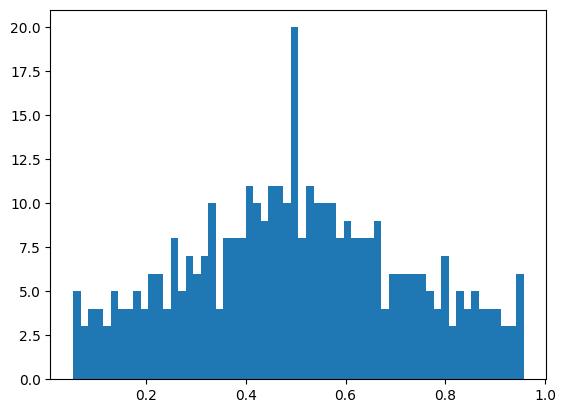

In [16]:
print('For the cases where both SL and TP are above 0:')

print('Minimum value is:', min(p_values))
print('Maximum value is:', max(p_values))

_ = plt.hist(p_values, bins=60)

In other cases:
When SL is 0, the p is close to 0. So the minimum value is: 2.745470106520066e-07
When TP is 0, the p is close to 1. So the maximum value is: 1.0000000000022924


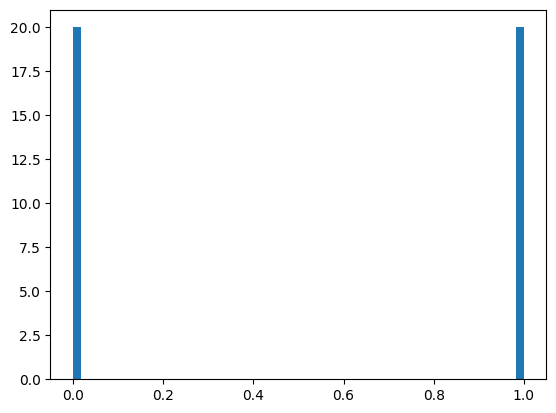

In [17]:
print('In other cases:')
p_boundary = [x for x in p_boundary if str(x) != 'nan']

print('When SL is 0, the p is close to 0. So the minimum value is:', min(p_boundary))
print('When TP is 0, the p is close to 1. So the maximum value is:', max(p_boundary))

_ = plt.hist(p_boundary, bins=60)

So, the range of p implied by Figure 13.1 goes from 0.085 to 0.974

### (c) What is the range of p implied by Figure 13.5, for a weekly betting frequency?

In [18]:
rPT = rSLm = np.linspace(0,10,21)
coeffs = {'forecast':0, 'hl':100, 'sigma':1}
output = batch(coeffs, nIter=1e5, maxHP=10, rPT=rPT, rSLm=rSLm)

20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440


In [19]:
# Assume weekly trading
n = 52

p_values = []
p_boundary = []
for el in output:
    tp, sl, _, _, SR = el
    sl = -sl
    
    a = (n + SR**2) * (tp - sl)**2
    b = (2 * n * sl - SR**2 * (tp - sl)) * (tp - sl)
    c = n * sl**2
    
    p = (-b + (b**2 - 4 * a * c)**(1/2)) / (2 * a)
    if tp == 0 or sl == 0:
        p_boundary.append(p) 

        continue

    p_values.append(p)

/tmp/ipykernel_34200/2547255386.py:14: RuntimeWarning: invalid value encountered in double_scalars
  p = (-b + (b**2 - 4 * a * c)**(1/2)) / (2 * a)


For the cases where both SL and TP are above 0:
Minimum value is: 0.04813971202776018
Maximum value is: 0.9529563561211634


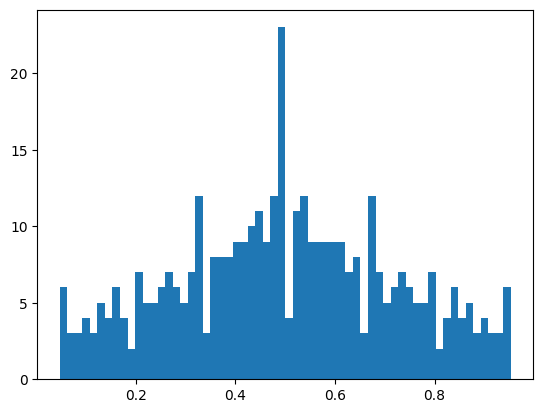

In [20]:
print('For the cases where both SL and TP are above 0:')

print('Minimum value is:', min(p_values))
print('Maximum value is:', max(p_values))

_ = plt.hist(p_values, bins=60)

In other cases:
When SL is 0, the p is close to 0. So the minimum value is: 5.931530678900251e-09
When TP is 0, the p is close to 1. So the maximum value is: 1.0000000001590137


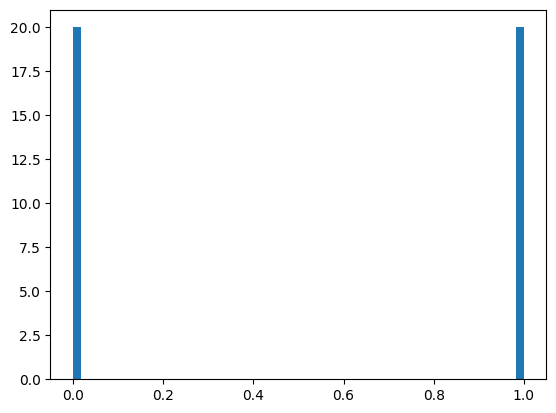

In [21]:
print('In other cases:')
p_boundary = [x for x in p_boundary if str(x) != 'nan']

print('When SL is 0, the p is close to 0. So the minimum value is:', min(p_boundary))
print('When TP is 0, the p is close to 1. So the maximum value is:', max(p_boundary))

_ = plt.hist(p_boundary, bins=60)

With an increased half-life from 5 to 100 we can see that the p distribution is much more narrow.

## Conclusion

The chapter provides formula solutions, showing dependencies between:
 * SR (or $\theta$) - Sharpe Ratio of the strategy;
 * n - trading frequency in trades per year;
 * p - precision rate of a trade;
 * $\pi_{-}$ and $\pi_{+}$ - Stop-Loss and Take-Profit Levels of a strategy;

As well as an algorithm for calculating the probability of strategy failure for a mixture of two Gaussian distributions. Required inputs are:
 * $\mu_{1}$, $\mu_{2}$, $\sigma_{1}$, $\sigma_{1}$ - mean and variance parameters of the distributions;
 * p - robability of picking one of them;
 * t - number of observations (total trades);
 * n - trading frequency (trades in a year);
 * tSR - target Sharpe Ratio;

Key takeways from the chapter:

 * From the first set of variables above, the Sharpe Ratio is most sensitive to changes in precision rate. Next, come the stop-loss or take-profit changes (and are symmetric), lastly goes trading frequency. 
 
 * PSR and Strategy Failure Algorithm can both be used to check if strategy fits the Sharpe Ratio requirements, however, the later is more accurate and takes into account only parameters that are under the control of the portfolio manager. 
 
 * From Examples in Chapter 13, if Stop-Loss levels are close to 0, the precision rate is close to 0; if Take-Profit is close to 0, the precision rate is close to 1.  

Papers used in the chapter:

* Lopez de Prado, M. and M. Foreman (2014): “A mixture of Gaussians approach to mathematical portfolio oversight: The EF3M algorithm.” Quantitative Finance, Vol. 14, No. 5, pp. 913–930. Available at https://ssrn.com/abstract=1931734. (Includes moments computation formulas. The EF3M algorithm itself aims to determine parameters of the two Gaussian distributions in a mixture.)

## Reference:

- Advances in Financial Machine Learning, Chapter-15